In [114]:
import os
import pandas as pd

import mar
import preprocessing

In [ ]:
pat_num = 9

In [116]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
output_dir = os.path.join(os.path.dirname(os.getcwd()), "output")

if not os.path.exists(os.path.join(data_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(data_dir, f'Patient{pat_num}'))

if not os.path.exists(os.path.join(output_dir, f'Patient{pat_num}')):
    os.makedirs(os.path.join(output_dir, f'Patient{pat_num}'))

In [117]:
mar_data = preprocessing.load_mar_data(data_dir, pat_num)
sickbay_data = preprocessing.load_sickbay_data(data_dir, pat_num)
sbs_data = preprocessing.load_retro_data(data_dir, pat_num, ignore_default=True)
accel_data = preprocessing.load_accel_data(data_dir, pat_num)
# ecg_data = preprocessing.load_ecg_data(data_dir, pat_num)

In [118]:
mar_narcotics, mar_paralytics, mar_alpha_agonists, mar_ketamines, mar_propofols, mar_etomidates, mar_benzodiazepines = mar.filter_mar(mar_data)
mar_classes = {'narcotics': mar_narcotics, 'paralytics': mar_paralytics, 'alpha_agonists': mar_alpha_agonists, 'ketamines': mar_ketamines, 'propofols': mar_propofols, 'etomidates': mar_etomidates, 'benzodiazepines': mar_benzodiazepines}

for mar_class in mar_classes:
    print(mar_class + " : " + str(mar_classes[mar_class].shape))

narcotics : (265, 4)
paralytics : (0, 4)
alpha_agonists : (506, 4)
ketamines : (12, 4)
propofols : (0, 4)
etomidates : (0, 4)
benzodiazepines : (0, 4)


In [119]:
drug_doses = {}
drug_concentrations = {}

for mar_class in mar_classes:
    if mar_classes[mar_class].shape[0] < 1:
        continue

    for drug_name in mar.classes()[mar_class]:
        drug_df = mar.filter_drug(mar_classes[mar_class], drug_name)
        
        if drug_df.shape[0] < 1:
            continue

        print(drug_name + " : " + str(drug_df.shape))

        drug_doses[drug_name] = mar.calculate_doses(drug_df)
        drug_concentrations[drug_name] = mar.calculate_concentrations_rk4(drug_doses[drug_name], elimination_rate=mar.elimination_rates()[drug_name])

print("")

for drug_name in drug_doses:
    print(drug_name + " : " + str(drug_doses[drug_name].shape))

fentanyl : (265, 4)
dexmedetomidine : (467, 4)
clonidine : (39, 4)
ketamine : (12, 4)

fentanyl : (21316, 4)
dexmedetomidine : (34222, 4)
clonidine : (25489, 4)
ketamine : (28777, 4)


In [120]:
# drug_concentrations_two_compartment = {}
# drug_concentrations_two_compartment['fentanyl'] = mar.calculate_concentrations_two_compartment_euler(drug_doses['fentanyl'], 90, 10)
# display(pd.DataFrame(drug_concentrations_two_compartment['fentanyl']).head())

In [121]:
# mar.plot_concentration(drug_concentrations_two_compartment, 'fentanyl', show=True, save=False)

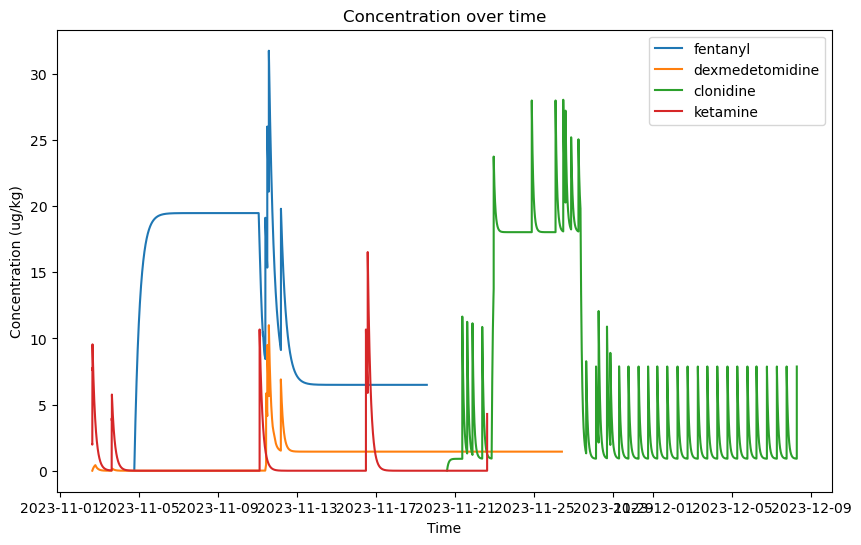

In [122]:
for drug_name in drug_concentrations:
    mar.plot_concentration(drug_concentrations, drug_name, show=False, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_{drug_name}_concentration.png'))

mar.plot_concentration(drug_concentrations, 'all', show=True, save=None)
# mar.plot_concentration(drug_concentrations, 'all', show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_all_concentration.png'))

In [123]:
metrics = {
    'heart_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'heart_rate': sickbay_data['heart_rate']
    }),
    'respiratory_rate': pd.DataFrame({
        'time': sickbay_data['time'],
        'respiratory_rate': sickbay_data['respiratory_rate']
    }),
    'acceleration': pd.DataFrame({
        'time': accel_data['time'],
        'acceleration': accel_data['a']
    }),
}

In [124]:
windows = [2, 60, 3600]

In [125]:
# for window in windows:
#     mar.plot_metrics(metrics, window=window, std=True, show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_metrics_{window}s.png'))
#     mar.plot_metrics(metrics, window=window, std=True, show=True, save=None)

In [126]:
start = max([df['time'].min() for df in metrics.values()])
stop = min([df['time'].max() for df in metrics.values()])

print(start)
print(stop)

2023-11-13 18:00:01
2023-11-24 01:14:58


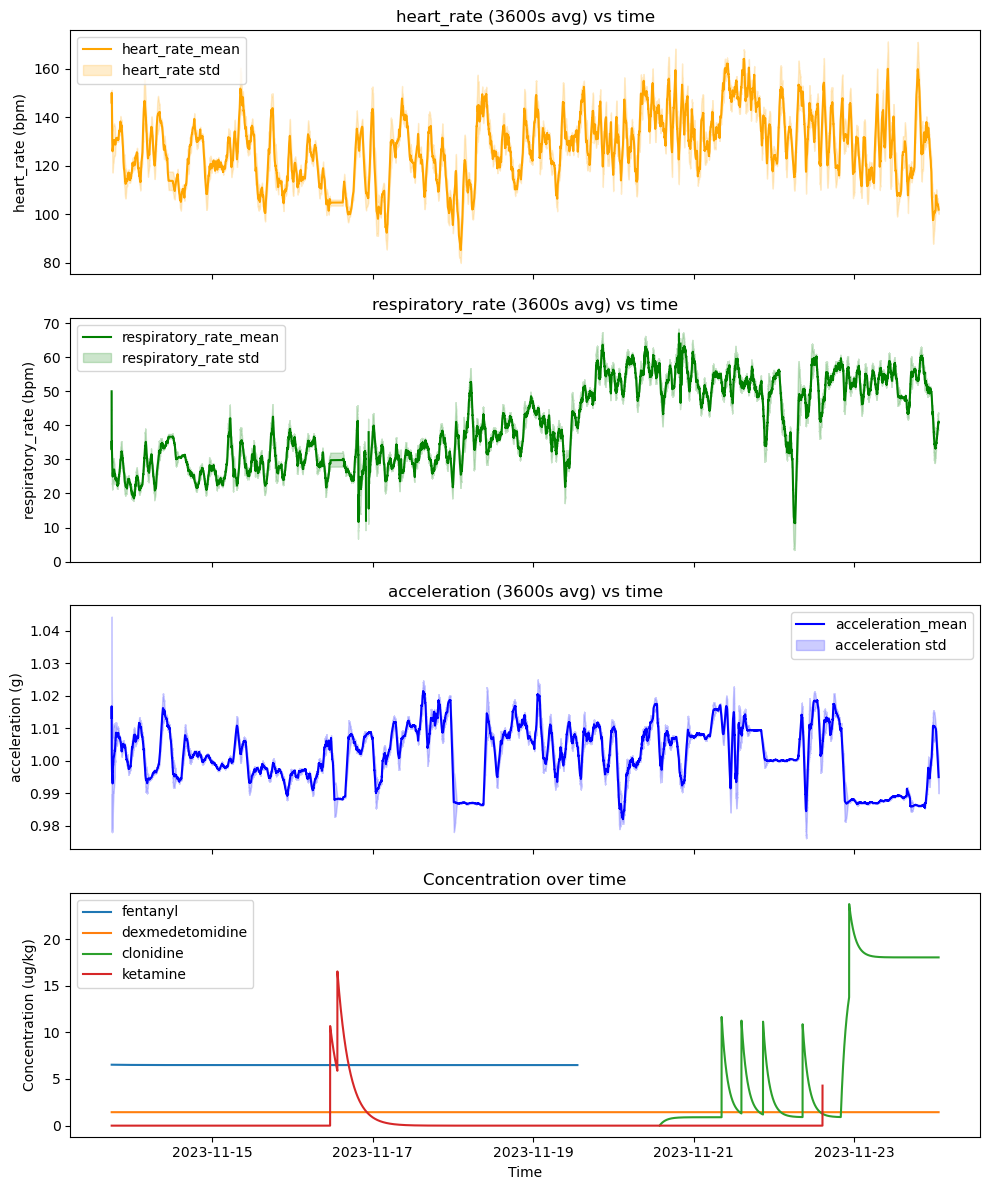

In [127]:
# mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name='all', window=3600, std=True, start=start, stop=stop, show=True, save=os.path.join(output_dir, f'Patient{pat_num}', f'Patient{pat_num}_metrics_and_concentrations_{3600}s.png'))
mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name='all', window=3600, std=True, start=start, stop=stop, show=True, save=None)

In [128]:
# start = '2023-11-21 00:00:00'
# stop = '2023-11-21 23:59:59'

# print(start)
# print(stop)

In [129]:
# mar.plot_metrics_and_concentrations(metrics, drug_concentrations, drug_name=['dexmedetomidine', 'clonidine'], window=3600, std=True, start=start, stop=stop, show=True, save=None)

In [130]:
sbs_data['MD_SBS'] = pd.to_numeric(sbs_data['MD_SBS'], errors='coerce')
sbs_data.dropna(subset=['MD_SBS'], inplace=True)
sbs_data.reset_index(drop=True, inplace=True)
sbs_data['MD_SBS'] = sbs_data['MD_SBS'].astype(int)

display(sbs_data)

,time,MD_SBS,TM_SBS,chunk #,SBS,Default,Stimulation,Stimulation_type,SedPRN,SedPRN_type,BlockPRN,Notes_MD,Lights,Inbed,Stimdurr_MD,Notes_TM,StimDur_TM
0,2023-01-20 20:02:00,0,0,NaN,0,NaN,yes,procedure,N,NaN,N,calms after suctioning,Y,Y,1.0,"Pt. slightly agitated, father strokes to calm",4min
1,2023-11-10 11:02:00,0,0,NaN,0,NaN,yes,touch,N,NaN,N,reacts to gentle touch and then falls asleep,Y,Y,3.0,Awake - woke up a little agitated,NaN
2,2023-11-13 00:38:00,-1,-1,NaN,-1,NaN,yes,procedure?,Y,NaN,N,not responding to gentle touch,Y,Y,NaN,Sleep,NaN
3,2023-11-13 18:31:00,0,0,NaN,0,NaN,yes,touch,Y,DEXMEDETOMIDINE,N,taking footprint and hardly responds,Y,Y,NaN,Awake but not reacting much - only head movement,NaN
4,2023-11-13 19:02:00,0,0,NaN,0,NaN,no,NaN,Y,NaN,N,"moving slightly, possibly sleeping?",Y,Y,NaN,Sleep,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2023-11-23 18:59:00,0,0,NaN,0,NaN,yes,suctioning,Y,NaN,N,moving arm a little and then calms,Y,Y,1.0,Pt. father tries to put in tube while nurse ho...,1min
359,2023-11-23 19:31:00,1,1,NaN,1,NaN,yes,touch,N,NaN,N,relaxing and watching ipad,Y,Y,1.0,Mother strokes pt. head; pt. awake and alert,1min
360,2023-11-23 20:07:00,0,0,NaN,0,NaN,yes,suctioning,N,NaN,N,agitated but calms after 2 minutes,Y,Y,1.0,"Nurse touch pt. head. Picked up around 9.05, t...",<1min
361,2023-11-23 20:34:00,0,0,NaN,0,NaN,yes,touch,N,NaN,N,responds and then goes back to watching ipad,Y,Y,1.0,"Father touch pt. head, someone cleans pt. face",3min


In [131]:
sbs_data_md = sbs_data[['time', 'MD_SBS']].copy()
sbs_data_md.rename(columns={'MD_SBS': 'sbs'}, inplace=True)

display(sbs_data_md)

,time,sbs
0,2023-01-20 20:02:00,0
1,2023-11-10 11:02:00,0
2,2023-11-13 00:38:00,-1
3,2023-11-13 18:31:00,0
4,2023-11-13 19:02:00,0
...,...,...
358,2023-11-23 18:59:00,0
359,2023-11-23 19:31:00,1
360,2023-11-23 20:07:00,0
361,2023-11-23 20:34:00,0


In [132]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

def plot_metrics_and_concentrations_and_sbs(data, drug_concentrations, sbs, drug_name='all', window=2, std=True, sbs_changes=False, start=None, stop=None, show=False, save=None):
    """
    Plot various metrics and drug concentration over time.
    
    Parameters:
        data (dict): Dictionary containing DataFrames for each metric.
        drug_concentrations (dict): Dictionary containing DataFrames of drug concentrations.
        sbs (DataFrame): DataFrame containing SBS data.
        drug_name (list): List of drug names to plot. Default is 'all'.
        window (int): Window size in seconds for moving average. Default is 2.
        std (bool): Whether to plot the standard deviation as a shaded area. Default is True.
        sbs_changes (bool): Whether to plot SBS only when there are changes. Default if False.
        start (str): Start time for the plot. If None, the plot will start from the beginning of the data. Default is None.
        stop (str): End time for the plot. If None, the plot will end at the last time point of the data. Default is None.
        show (bool): Whether to show the plot. Default is True.
        save (str): File path to save the plot. If None, the plot will not be saved. Default is None.
    """
    data = data.copy()
    drug_concentrations = drug_concentrations.copy()

    for metric in data:
        data[metric][metric] = data[metric][metric].rolling(window=window//2, min_periods=1).mean()
        
        if std:
            data[metric][f'{metric}_std'] = data[metric][metric].rolling(window=window//2, min_periods=1).std()

    _, axs = plt.subplots(len(data)+1, 1, figsize=(10, 3*(len(data)+1)), sharex=True)

    for ax, metric in enumerate(data):
        if metric == "heart_rate":
            color = 'orange'
            ylabel = 'heart_rate (bpm)'
        elif metric == 'respiratory_rate':
            color = 'green'
            ylabel = 'respiratory_rate (bpm)'
        elif metric == 'acceleration':
            color = 'blue'
            ylabel = 'acceleration (g)'
        else:
            color = 'purple'
            ylabel = f'{metric}'

        if start is None:
            start = min([data[metric]['time'].iloc[0] for metric in data])
        
        if stop is None:
            stop = max([data[metric]['time'].iloc[-1] for metric in data])

        data[metric] = data[metric][(data[metric]['time'] >= pd.to_datetime(start)) & (data[metric]['time'] <= pd.to_datetime(stop))].reset_index(drop=True)

        datum = data[metric]
        axs[ax].plot(datum['time'], datum[f'{metric}'], label=f'{metric}_mean', color=color)

        if std:
            axs[ax].fill_between(datum['time'], 
                                 datum[f'{metric}'] - datum[f'{metric}_std'], 
                                 datum[f'{metric}'] + datum[f'{metric}_std'], 
                                 color=color, alpha=0.2, label=f'{metric} std')

        if window == 2:
            axs[ax].set_title(f'{metric} vs time')
        else:
            axs[ax].set_title(f'{metric} ({window}s avg) vs time')

        axs[ax].set_ylabel(ylabel)
        axs[ax].legend()

    axs[-1].set_title('Drug Concentration vs Time')

    if not isinstance(drug_name, list):
        drug_name = [drug_name]

    if drug_name == ['all']:
        drug_name = drug_concentrations.keys()
        title = ''
    else:
        title = ', '.join(drug_name)

    if start is None:
        start = min([df['time'].iloc[0] for df in drug_concentrations.values()])

    if stop is None:
        stop = max([df['time'].iloc[-1] for df in drug_concentrations.values()])
    
    for drug in drug_concentrations:
        drug_concentrations[drug] = drug_concentrations[drug][(drug_concentrations[drug]['time'] >= pd.to_datetime(start)) & (drug_concentrations[drug]['time'] <= pd.to_datetime(stop))].reset_index(drop=True)

    for drug in drug_name:
        if drug_concentrations[drug].empty:
            continue
        
        axs[-1].plot(drug_concentrations[drug]['time'], drug_concentrations[drug]['concentration'], label=drug)
        axs[-1].set_xlabel('Time')
        axs[-1].set_ylabel('Concentration (ug/kg)')
        axs[-1].legend()

        if drug_name == drug_concentrations.keys():
            axs[-1].set_title('Concentration over time')
        else:
            axs[-1].set_title(f'Concentration of {title} over time')

    sbs_df = sbs.copy()
    sbs_df = sbs_df[(sbs_df['time'] >= pd.to_datetime(start)) & (sbs_df['time'] <= pd.to_datetime(stop))].reset_index(drop=True)

    if sbs_changes:
        sbs_df = sbs_df[sbs_df['sbs'].diff().fillna(sbs_df['sbs']).astype(bool)]

    color_map = {
        -2: 'purple',
        -1: 'blue',
         0: 'green',
         1: 'yellow',
         2: 'red',
         3: 'black',
    }

    for _, row in sbs_df.iterrows():
        t = row['time']
        c = color_map.get(row['sbs'], 'black')
        for ax in axs:
            ax.axvline(t, color=c, linestyle='-', alpha=0.2)

    # 1) Capture the existing drug handles & labels
    drug_handles, drug_labels = axs[-1].get_legend_handles_labels()

    # 2) Re‑draw the drug legend in the upper left
    drug_legend = axs[-1].legend(
        handles=drug_handles,
        labels=drug_labels,
        title='Drug',
        loc='upper left',
        frameon=True
    )

    # 3) Build SBS handles & labels
    sbs_handles = []
    sbs_labels  = []
    for level, color in color_map.items():
        sbs_handles.append(Line2D([0], [0], color=color, linestyle='--', lw=2))
        sbs_labels.append(f'SBS {level}')

    # 4) Draw the SBS legend in the upper right
    sbs_legend = axs[-1].legend(
        handles=sbs_handles,
        labels=sbs_labels,
        title='SBS',
        loc='upper right',
        frameon=True
    )

    # 5) Re‑add the drug legend so both show
    axs[-1].add_artist(drug_legend)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save)

    if show:
        plt.show()
    
    plt.close()

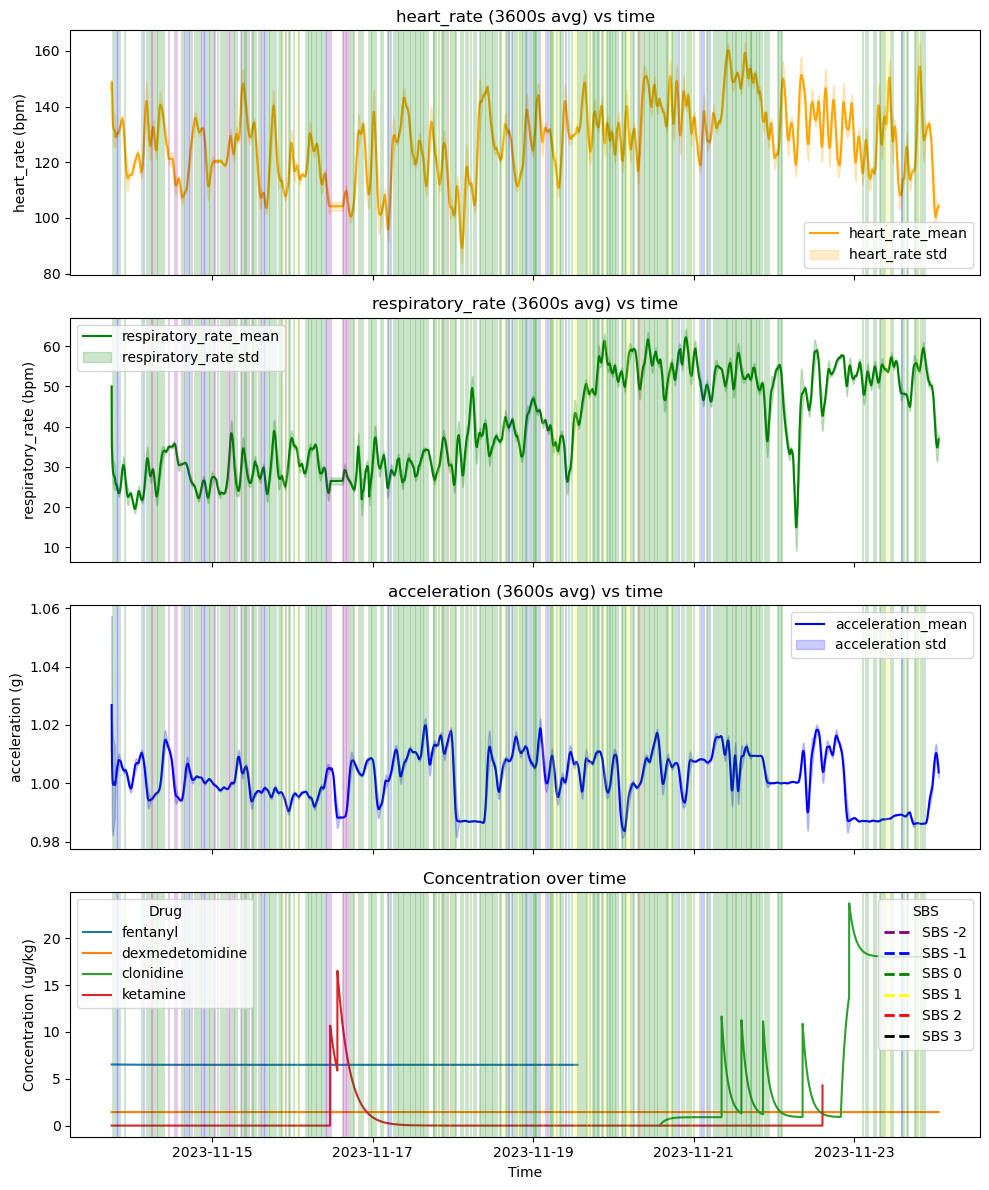

In [133]:
plot_metrics_and_concentrations_and_sbs(data=metrics, drug_concentrations=drug_concentrations, sbs=sbs_data_md, drug_name='all', window=3600, std=True, sbs_changes=False, start=start, stop=stop, show=True, save=False)